In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets#t1

https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

# load the data

In [2]:
refdf = pd.read_excel('../reference_10cc.xlsx')

In [3]:
refdf = refdf.loc[~refdf.Group.isin(['Axenic'])]

In [4]:
refdf.head()

,Sample,id,replicate,transfer,transfer day,heterotroph,full name,Group,t,day,FL,ref_Bp[N],ref_Bp[C]
0,10A0,10,A,0,0,HOT5_F3,Marinovum 5F3,Weak,0.0,0.000000,0.061,1.430467,9.476845
1,10A0,10,A,0,0,HOT5_F3,Marinovum 5F3,Weak,93480.0,1.081944,0.088,2.063625,13.671514
2,10A0,10,A,0,0,HOT5_F3,Marinovum 5F3,Weak,187020.0,2.164583,0.121,2.837484,18.798332
3,10A0,10,A,0,0,HOT5_F3,Marinovum 5F3,Weak,237360.0,2.747222,0.189,4.432103,29.362685
4,10A0,10,A,0,0,HOT5_F3,Marinovum 5F3,Weak,324360.0,3.754167,0.275,6.448828,42.723483


In [5]:
refdf.describe()

,id,transfer,transfer day,t,day,FL,ref_Bp[N],ref_Bp[C]
count,1998.000000,1998.0,1998.0,1.998000e+03,1998.000000,1998.000000,1998.000000,1998.000000
mean,6.333333,0.0,0.0,4.287948e+06,49.629026,0.249843,5.858881,38.815088
std,2.982170,0.0,0.0,3.043224e+06,35.222497,0.489585,11.480917,76.061077
min,2.000000,0.0,0.0,0.000000e+00,0.000000,-0.052000,-1.219415,-8.078622
25%,4.000000,0.0,0.0,1.616700e+06,18.711806,0.043000,1.008362,6.680399
50%,6.000000,0.0,0.0,3.740850e+06,43.296875,0.095000,2.227777,14.759021
75%,9.000000,0.0,0.0,6.894300e+06,79.795139,0.228500,5.358389,35.499330
max,11.000000,0.0,0.0,1.112550e+07,128.767361,6.072667,142.405747,943.438071


In [6]:
refdf.columns

Index(['Sample', 'id', 'replicate', 'transfer', 'transfer day', 'heterotroph',
       'full name', 'Group', 't', 'day', 'FL', 'ref_Bp[N]', 'ref_Bp[C]'],
      dtype='object')

# create dataset using shuffling of data

In [7]:
groupby_cols = [ 'id',  'heterotroph',
       'full name',  'Group',  't', 'day',]

refdf_samples = refdf.groupby(groupby_cols).sample(50, replace=True, random_state=12345)
refdf_samples['sample_number'] = refdf_samples.groupby(groupby_cols).cumcount()

In [8]:
refdf_samples['shuffle_id'] = refdf_samples['id'].astype(str) + '_' + refdf_samples['sample_number'].astype(str)

# Compute features

In [9]:
def _compute_max_features(df, groupby_col, nutrient, biomass_prefix):
    refmaxbp_df = df.loc[df.groupby(groupby_col)[f'{biomass_prefix}[{nutrient}]'].idxmax()].reset_index(drop=True)
    refmaxbp_df = refmaxbp_df.set_index(groupby_col)
    refmaxbp_df = refmaxbp_df[['day', f'{biomass_prefix}[{nutrient}]']]
    refmaxbp_df.rename(columns={
        'day' : f'max_{nutrient}day', 
        f'{biomass_prefix}[{nutrient}]' : f'max_{nutrient}biomass',
    }, inplace=True)
    return refmaxbp_df

def _compute_mean_features(df, groupby_col, nutrient, biomass_prefix):
    min_day = 30
    max_day = 60
    lterm_df = df.loc[df.day.ge(min_day) & df.day.le(max_day)]
    reflterm_df = lterm_df.groupby(groupby_col)[f'{biomass_prefix}[{nutrient}]'].agg(['mean', 'std', 'median'])
    reflterm_df.rename(columns={
        'mean' : f'mean_{nutrient}biomass',
        'median' : f'median_{nutrient}biomass',
        'std' : f'std_{nutrient}biomass',
    }, inplace=True)
    return reflterm_df

def _compute_lastday_features(df, groupby_col, nutrient, biomass_prefix):
    lod_lastday_threshold = 2
    refmaxday_df = df.loc[df[f'{biomass_prefix}[{nutrient}]'].ge(lod_lastday_threshold)].groupby(groupby_col).day.max()
    #refmaxday_df.rename(columns=dict(day=f'last_day{nutrient}'), inplace=True)
    refmaxday_df.name = f'last_day{nutrient}'
    return refmaxday_df

def _compute_features(df, groupby_col, biomass_prefix):
    #return (
    df_list = (
        [_compute_max_features(df, groupby_col, nutrient, biomass_prefix) for nutrient in 'NC'] +
        [_compute_mean_features(df, groupby_col, nutrient, biomass_prefix) for nutrient in 'NC'] +
        [_compute_lastday_features(df, groupby_col, nutrient, biomass_prefix) for nutrient in 'NC']
    )
    df_merge = df_list[0].join(df_list[1:])
        
    df_merge.fillna(0, inplace=True) # for last day
    return df_merge
    

In [10]:
# log the biomass
def add_log_cols(df, biomass_prefix):
    lod_threshold = 1
    for nutrient in 'NC':
        df[f'log_{nutrient}biomass'] = np.log(df[f'{biomass_prefix}[{nutrient}]'].clip(lower=lod_threshold))
    return df

In [11]:
refdf_samples = add_log_cols(refdf_samples, 'ref_Bp')

In [12]:
x_groupby_col = ['shuffle_id', 'id', 'full name', 'Group']
x_log_col = [f'log_{nutrient}biomass' for nutrient in 'NC']

pfeature_df = _compute_features(refdf_samples, x_groupby_col, 'ref_Bp')
prefdf_samples = refdf_samples.pivot(index=x_groupby_col, values=x_log_col, columns='day')
prefdf_samples.columns = [f'{col}_{day:2.2f}' for col,day in prefdf_samples.columns.values]

logistic_Nfeatures = [c for c in prefdf_samples.columns if c.startswith('log_Nbiomass')]
logistic_Cfeatures = [c for c in prefdf_samples.columns if c.startswith('log_Cbiomass')]
forest_features = pfeature_df.columns
X = pfeature_df.join(prefdf_samples)
y = X.index.get_level_values(3)


In [13]:
y.value_counts()

Weak         59688
Strong       51213
Sustained    37064
Inhibited    35961
Name: Group, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=345)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((110355, 160), (110355,), (73571, 160), (73571,))

# Stacking classifier

The goal is to create multiple classifiers:
1. randomforest based on generated features: last day, max day, max value, mean late biomass (N & C), std late biomass (N & C)
2. logical regression based on N biomass
3. logical regression based on C biomass
4. tslearn based on N biomass 
5. tslearn based on C biomass 

and than combine the results using a stacking classifier

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier
# Classifiers
clf_features = RandomForestClassifier(n_estimators=1000, n_jobs=-1, #max_depth=3
                                     )
clf_logisticN = LogisticRegression(penalty='l2', C=0.1, max_iter=10000, multi_class='ovr')
clf_logisticC = LogisticRegression(penalty='l2', C=0.1, max_iter=10000, multi_class='ovr')
clf_meta = LogisticRegression()

pipe_logisticN = Pipeline([
    ('select', ColumnTransformer([('sel', 'passthrough', logistic_Nfeatures)], remainder='drop')),  
    ('scale', StandardScaler()),    
    ('clf', clf_logisticN)
],
    memory='/tmp/Osnat/sklearn_cache',
)
pipe_logisticC = Pipeline([
    ('select', ColumnTransformer([('sel', 'passthrough', logistic_Cfeatures)], remainder='drop')),
    ('scale', StandardScaler()),    
    ('clf', clf_logisticC)
],
    memory='/tmp/Osnat/sklearn_cache',
)
pipe_forest = Pipeline([
    ('select', ColumnTransformer([('sel', 'passthrough', forest_features)], remainder='drop')),  
    ('scale', StandardScaler()),    
    ('clf', clf_features)
],
    memory='/tmp/Osnat/sklearn_cache',
)



stack = StackingClassifier(
    estimators=[
        ('logisticN', pipe_logisticN),
        ('logisticC', pipe_logisticC),
        ('ForestFeatures', pipe_forest),
    ],
    final_estimator=clf_meta,
    n_jobs = -1, verbose=True
)

stack.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.3s finished


StackingClassifier(estimators=[('logisticN',
                                Pipeline(memory='/tmp/Osnat/sklearn_cache',
                                         steps=[('select',
                                                 ColumnTransformer(transformers=[('sel',
                                                                                  'passthrough',
                                                                                  ['log_Nbiomass_0.00',
                                                                                   'log_Nbiomass_1.08',
                                                                                   'log_Nbiomass_2.16',
                                                                                   'log_Nbiomass_2.75',
                                                                                   'log_Nbiomass_3.75',
                                                                                   'log_Nbiomass_4.70',
                                                                                   'log_Nbiomass_5.72',
                                                                                   'log_Nbiomass_6.73',
                                                                                   'log_Nbiomass_7.98',
                                                                                   'log_Nbiomas...
                                                                                  Index(['max_Nday', 'max_Nbiomass', 'max_Cday', 'max_Cbiomass', 'mean_Nbiomass',
       'std_Nbiomass', 'median_Nbiomass', 'mean_Cbiomass', 'std_Cbiomass',
       'median_Cbiomass', 'last_dayN', 'last_dayC'],
      dtype='object'))])),
                                                ('scale', StandardScaler()),
                                                ('clf',
                                                 RandomForestClassifier(n_estimators=1000,
                                                                        n_jobs=-1))]))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   verbose=True)

In [83]:
forest_features

Index(['max_Nday', 'max_Nbiomass', 'max_Cday', 'max_Cbiomass', 'mean_Nbiomass',
       'std_Nbiomass', 'median_Nbiomass', 'mean_Cbiomass', 'std_Cbiomass',
       'median_Cbiomass', 'last_dayN', 'last_dayC'],
      dtype='object')

In [16]:
y_pred_prop = stack.predict_proba(X_test)
y_pred = stack.predict(X_test)

In [17]:
print(stack.score(X_train, y_train), stack.score(X_test, y_test))
print(metrics.classification_report(y_test, y_pred))

1.0 1.0
              precision    recall  f1-score   support

   Inhibited       1.00      1.00      1.00     14345
      Strong       1.00      1.00      1.00     20578
   Sustained       1.00      1.00      1.00     14734
        Weak       1.00      1.00      1.00     23914

    accuracy                           1.00     73571
   macro avg       1.00      1.00      1.00     73571
weighted avg       1.00      1.00      1.00     73571



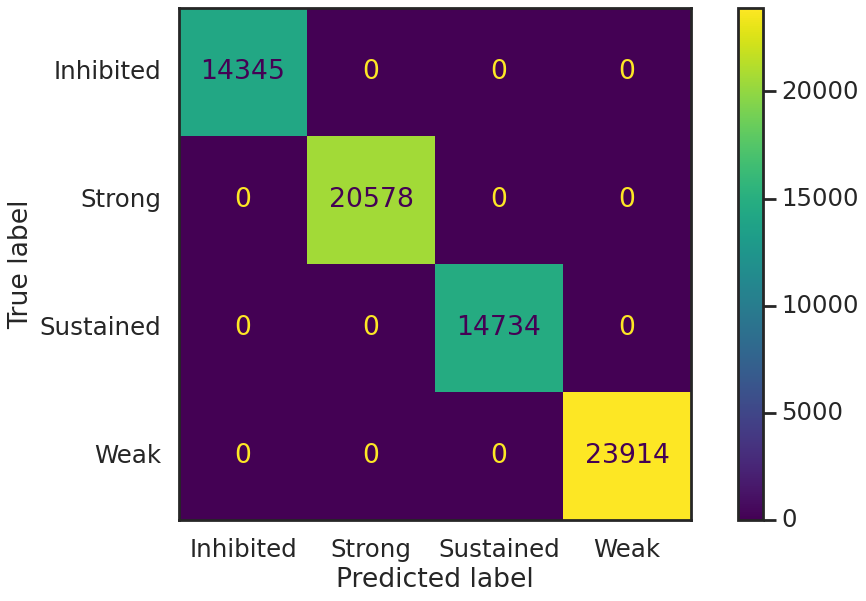

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=stack.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=stack.classes_)
disp.plot()
plt.show()

In [19]:
y_pred_prop

array([[2.79034500e-05, 9.99915121e-01, 2.79322235e-05, 2.90435209e-05],
       [2.42397351e-05, 2.49429452e-05, 2.43964428e-05, 9.99926421e-01],
       [2.41932933e-05, 2.48950103e-05, 2.43043786e-05, 9.99926607e-01],
       ...,
       [2.42745294e-05, 2.49765815e-05, 2.44589163e-05, 9.99926290e-01],
       [3.72706989e-05, 3.83841786e-05, 9.99885525e-01, 3.88197387e-05],
       [2.41469240e-05, 2.48474678e-05, 2.42135130e-05, 9.99926792e-01]])

In [20]:
df_predicted = pd.DataFrame(y_pred_prop, columns=stack.classes_)
df_predicted['y'] = y_test
df_predicted
mdf_predicted = df_predicted.melt(id_vars='y', var_name='predicted', value_name='prob')
mdf_predicted['predicted_correctly'] = mdf_predicted['y'] == mdf_predicted['predicted']


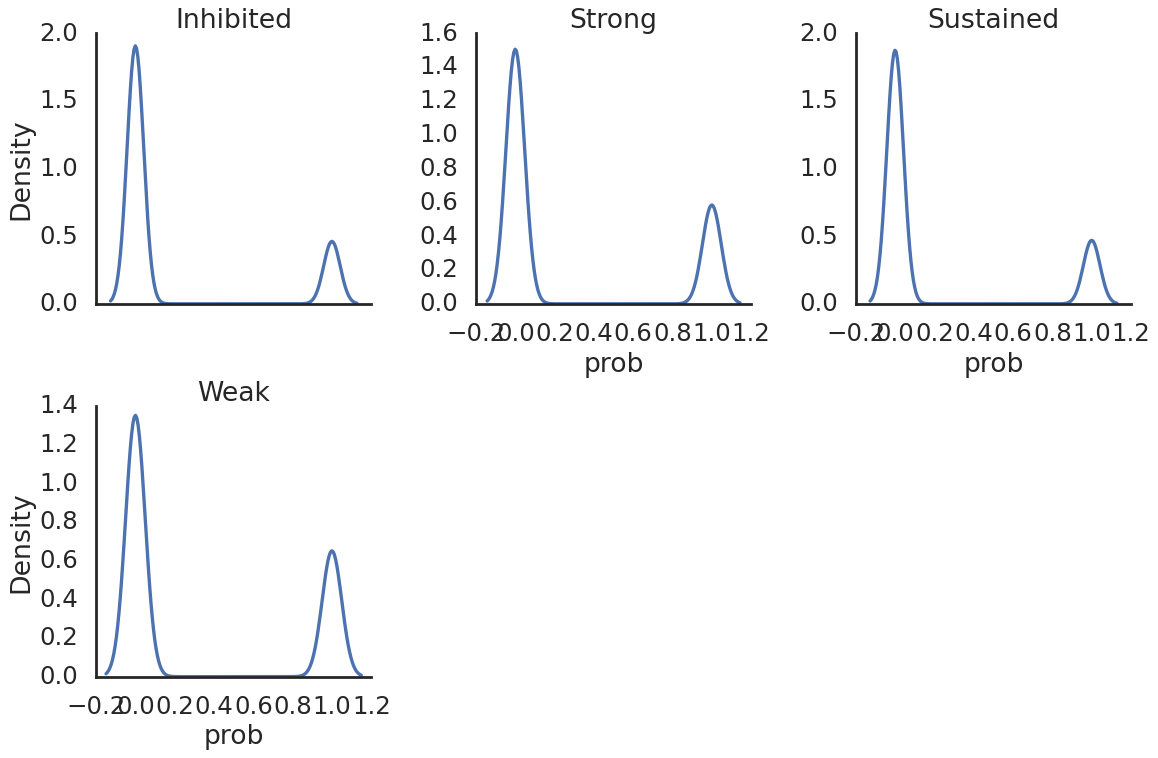

In [21]:
g=sns.displot(data=mdf_predicted, #.loc[mdf_predicted.predicted.isin([3])], 
            x='prob',
            kind='kde',
            col='predicted',
            #hue='predicted_correctly',
            col_wrap=3,
              #log_scale=True,
          #clip=(0,1),
              facet_kws=dict(sharey=False),
           )
g.set_titles(col_template='{col_name}')
#g.set(yscale='log')

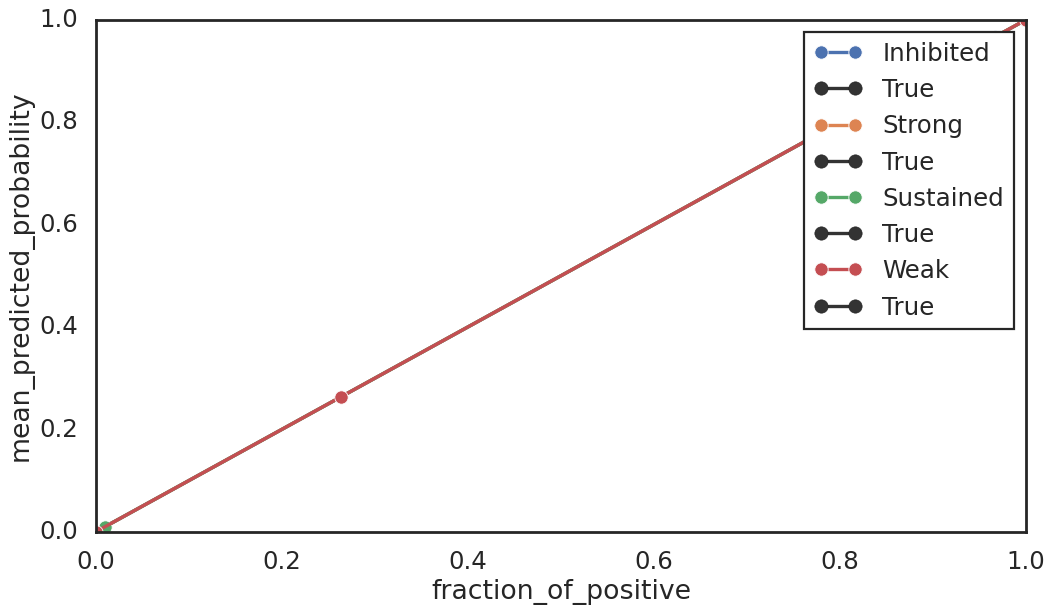

In [22]:
from sklearn.calibration import calibration_curve
for class_ in stack.classes_:
    sns.lineplot(
    #sns.scatterplot(
        data=pd.DataFrame(calibration_curve(
            y_test==class_, df_predicted[class_], 
            strategy='quantile', 
            n_bins=10,)).T,
        x=0, y=1, markers=True, style=True,
        label=class_
    )
plt.gca().set(xlabel='fraction_of_positive', ylabel='mean_predicted_probability')
plt.show()

# test on original experiment measurements

In [23]:
refdfX = add_log_cols(refdf, 'ref_Bp')

In [24]:
x_groupby_col = ['Sample', 'id', 'full name', 'Group']
x_log_col = [f'log_{nutrient}biomass' for nutrient in 'NC']

preffeature_df = _compute_features(refdfX, x_groupby_col, 'ref_Bp')
prefdfX = refdfX.pivot(index=x_groupby_col, values=x_log_col, columns='day')
prefdfX.columns = [f'{col}_{day:2.2f}' for col,day in prefdfX.columns.values]

X_ref = preffeature_df.join(prefdfX)
y_ref = X_ref.index.get_level_values(3)


In [25]:
y_ref_pred_prop = stack.predict_proba(X_ref)
y_ref_pred = stack.predict(X_ref)

In [26]:
max_ref_prob = np.amax(y_ref_pred_prop, axis=1)
max_ref_prob

array([0.99991937, 0.99989457, 0.99992683, 0.99992681, 0.99992653,
       0.99980571, 0.99991499, 0.99991518, 0.99966678, 0.99988181,
       0.99988191, 0.99988191, 0.99988132, 0.99988192, 0.99988181,
       0.99900793, 0.99991506, 0.99991521, 0.99988516, 0.99988524,
       0.99988536, 0.99988498, 0.99988547, 0.99988533, 0.99992683,
       0.9999268 , 0.99992332])

In [27]:
refdf_predicted_classes = pd.DataFrame({
    'y' : y_ref,
    'y_pred' : y_ref_pred,
    'max_prob' : max_ref_prob,
})
refdf_predicted_classes

,y,y_pred,max_prob
0,Weak,Weak,0.999919
1,Weak,Weak,0.999895
2,Weak,Weak,0.999927
3,Weak,Weak,0.999927
4,Weak,Weak,0.999927
5,Weak,Weak,0.999806
6,Strong,Strong,0.999915
7,Strong,Strong,0.999915
8,Strong,Strong,0.999667
9,Inhibited,Inhibited,0.999882


# classify simulations

In [28]:
dpath = '../results'
sim_df = pd.read_csv(os.path.join(dpath,'monte4_df.csv.gz',))


In [29]:
sim_df = sim_df[['run_id', 'day', 'Bptotal[N]','Bptotal[C]']]

In [30]:
min_values = sim_df.groupby('run_id').min().min(axis=1)
bad_ids_negative_values = set(min_values[min_values< 0].index)
len(bad_ids_negative_values)

1019

In [31]:
max_values = sim_df.groupby('run_id').max().max(axis=1)
bad_ids_toobig_values = set(max_values[max_values>1e5].index)
len(bad_ids_toobig_values)

4

In [32]:
sim_df = sim_df.loc[~sim_df.run_id.isin(bad_ids_negative_values | bad_ids_toobig_values)].copy()

In [33]:
sim_df = add_log_cols(sim_df, 'Bptotal')

In [34]:
sim_groupby_col = ['run_id', ]# 'Group']
sim_log_col = [f'log_{nutrient}biomass' for nutrient in 'NC']

psim_feature_df = _compute_features(sim_df, sim_groupby_col, 'Bptotal')
psim_df = sim_df.pivot(index=sim_groupby_col, values=sim_log_col, columns='day')
psim_df.columns = [f'{col}_{day:2.2f}' for col,day in psim_df.columns.values]

X_sim = psim_feature_df.join(psim_df)


In [35]:
[c for c in X_sim.columns if c not in X_train.columns], [c for c in X_train.columns if c not in X_sim.columns]

(['log_Nbiomass_72.78', 'log_Cbiomass_72.78'],
 ['log_Nbiomass_72.77', 'log_Cbiomass_72.77'])

In [36]:
X_sim.rename(columns={
    'log_Nbiomass_72.78' : 'log_Nbiomass_72.77',
    'log_Cbiomass_72.78' : 'log_Cbiomass_72.77',
}, inplace=True)

In [37]:
[c for c in X_sim.columns if c not in X_train.columns],[c for c in X_train.columns if c not in X_sim.columns]

([], [])

In [38]:
X_sim.loc[X_sim.isna().sum(axis=1).ge(1)]

,max_Nday,max_Nbiomass,max_Cday,max_Cbiomass,mean_Nbiomass,std_Nbiomass,median_Nbiomass,mean_Cbiomass,std_Cbiomass,median_Cbiomass,...,log_Cbiomass_94.92,log_Cbiomass_96.83,log_Cbiomass_98.00,log_Cbiomass_100.74,log_Cbiomass_107.71,log_Cbiomass_110.94,log_Cbiomass_115.85,log_Cbiomass_118.79,log_Cbiomass_121.78,log_Cbiomass_128.77
run_id,,,,,,,,,,,,,,,,,,,,,
monte4_OVERFLOW_19_monte_vpro_3365_OVERFLOW_51_lowN_all_OVERFLOW_h-2074384540759412348,10.834722,48.653135,10.834722,322.327022,0.221952,0.282856,0.084390,1.470429,1.873923,0.559084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monte4_OVERFLOW_23_monte_vpro_3130_OVERFLOW_44_lowN_all_OVERFLOW_h-2074384540759412348,6.731944,28.109097,6.731944,186.222766,0.120056,0.139613,0.056419,0.795372,0.924938,0.373776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
monte4_OVERFLOW_24_monte_vpro_3125_OVERFLOW_41_lowN_all_OVERFLOW_h-2074384540759412348,5.720139,134.980395,5.720139,894.245117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monte4_OVERFLOW_36_monte_vpro_494_OVERFLOW_31_lowN_all_OVERFLOW_h-2074384540759412348,3.754167,5.836880,3.754167,38.669328,0.000349,0.000521,0.000080,0.002312,0.003455,0.000531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monte4_OVERFLOW_41_monte_vpro_3333_OVERFLOW_37_lowN_all_OVERFLOW_h-2074384540759412348,9.745833,53.832826,9.745833,356.642469,0.116595,0.158121,0.036975,0.772440,1.047551,0.244959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
monte4_ROS_94_monte_vpro_3887_ROS_44_lowN_all_ROS_h5853139000967720769,7.984028,43.963516,7.984028,428.393762,0.000518,0.000971,0.000027,0.005119,0.009589,0.000270,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
monte4_ROS_95_monte_vpro_4334_ROS_58_lowN_all_ROS_h5853139000967720769,6.731944,23.983189,6.731944,225.824014,0.000133,0.000252,0.000006,0.001317,0.002503,0.000061,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
monte4_ROS_96_monte_vpro_3504_ROS_34_lowN_all_ROS_h5853139000967720769,6.731944,39.749289,6.731944,384.000751,0.001387,0.002408,0.000133,0.013727,0.023821,0.001318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [39]:
X_sim = X_sim.loc[~X_sim.isna().sum(axis=1).ge(1)]

In [40]:
X_sim.loc[X_sim.isna().sum(axis=1).ge(1)]

,max_Nday,max_Nbiomass,max_Cday,max_Cbiomass,mean_Nbiomass,std_Nbiomass,median_Nbiomass,mean_Cbiomass,std_Cbiomass,median_Cbiomass,...,log_Cbiomass_94.92,log_Cbiomass_96.83,log_Cbiomass_98.00,log_Cbiomass_100.74,log_Cbiomass_107.71,log_Cbiomass_110.94,log_Cbiomass_115.85,log_Cbiomass_118.79,log_Cbiomass_121.78,log_Cbiomass_128.77
run_id,,,,,,,,,,,,,,,,,,,,,


In [41]:
X_sim.max()

max_Nday                128.767361
max_Nbiomass            335.740205
max_Cday                128.767361
max_Cbiomass           2224.278861
mean_Nbiomass           306.479875
                          ...     
log_Cbiomass_110.94       7.705770
log_Cbiomass_115.85       7.706300
log_Cbiomass_118.79       7.706558
log_Cbiomass_121.78       7.706783
log_Cbiomass_128.77       7.707188
Length: 160, dtype: float64

In [42]:
refdf.max()

Sample                                     9C0
id                                          11
replicate                                    C
transfer                                     0
transfer day                                 0
heterotroph                            nitzsch
full name       Sulfitobacter pseudonitzschiae
Group                                     Weak
t                                   11125500.0
day                                 128.767361
FL                                    6.072667
ref_Bp[N]                           142.405747
ref_Bp[C]                           943.438071
log_Nbiomass                           4.95868
log_Cbiomass                          6.849531
dtype: object

In [43]:
y_sim_pred_prop = stack.predict_proba(X_sim)
y_sim_pred = stack.predict(X_sim)

In [44]:
list(zip(*np.unique(y_sim_pred, return_counts=True)))

[('Inhibited', 410), ('Strong', 21), ('Sustained', 226), ('Weak', 41939)]

In [45]:
max_sim_prob = np.amax(y_sim_pred_prop, axis=1)
max_sim_prob

array([0.99969029, 0.99965472, 0.99913264, ..., 0.99969422, 0.99969735,
       0.99955446])

In [46]:
df_predicted_classes = pd.DataFrame({
    'run_id' : X_sim.index,
    'y_pred' : y_sim_pred,
    'max_prob' : max_sim_prob,
})
df_predicted_classes

,run_id,y_pred,max_prob
0,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,Weak,0.999690
1,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,Weak,0.999655
2,monte4_EXOENZYME_100_monte_vpro_3135_EXOENZYME...,Weak,0.999133
3,monte4_EXOENZYME_100_monte_vpro_3143_EXOENZYME...,Weak,0.999849
4,monte4_EXOENZYME_100_monte_vpro_3147_EXOENZYME...,Weak,0.999652
...,...,...,...
42591,monte4_ROS_9_monte_vpro_4197_ROS_12_lowN_all_R...,Weak,0.999151
42592,monte4_ROS_9_monte_vpro_4434_ROS_13_lowN_all_R...,Weak,0.999698
42593,monte4_ROS_9_monte_vpro_4538_ROS_1_lowN_all_RO...,Weak,0.999694
42594,monte4_ROS_9_monte_vpro_4738_ROS_2_lowN_all_RO...,Weak,0.999697


In [47]:
df_predicted_classes[['idx', 'media', 'which', 'model', 'hash']] = df_predicted_classes.run_id.str.rsplit('_', n=4, expand=True)


In [48]:
class_meta_df  = refdf[['id', 'full name', 'Group']].value_counts().reset_index()

In [49]:
df_predicted_classes['Group'] = df_predicted_classes['y_pred']

In [50]:
df_predicted_classes

,run_id,y_pred,max_prob,idx,media,which,model,hash,Group
0,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,Weak,0.999690,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,lowN,all,EXOENZYME,h1628948357718170805,Weak
1,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,Weak,0.999655,monte4_EXOENZYME_100_monte_vpro_31007_EXOENZYM...,lowN,all,EXOENZYME,h1628948357718170805,Weak
2,monte4_EXOENZYME_100_monte_vpro_3135_EXOENZYME...,Weak,0.999133,monte4_EXOENZYME_100_monte_vpro_3135_EXOENZYME_37,lowN,all,EXOENZYME,h1628948357718170805,Weak
3,monte4_EXOENZYME_100_monte_vpro_3143_EXOENZYME...,Weak,0.999849,monte4_EXOENZYME_100_monte_vpro_3143_EXOENZYME_43,lowN,all,EXOENZYME,h1628948357718170805,Weak
4,monte4_EXOENZYME_100_monte_vpro_3147_EXOENZYME...,Weak,0.999652,monte4_EXOENZYME_100_monte_vpro_3147_EXOENZYME_23,lowN,all,EXOENZYME,h1628948357718170805,Weak
...,...,...,...,...,...,...,...,...,...
42591,monte4_ROS_9_monte_vpro_4197_ROS_12_lowN_all_R...,Weak,0.999151,monte4_ROS_9_monte_vpro_4197_ROS_12,lowN,all,ROS,h5853139000967720769,Weak
42592,monte4_ROS_9_monte_vpro_4434_ROS_13_lowN_all_R...,Weak,0.999698,monte4_ROS_9_monte_vpro_4434_ROS_13,lowN,all,ROS,h5853139000967720769,Weak
42593,monte4_ROS_9_monte_vpro_4538_ROS_1_lowN_all_RO...,Weak,0.999694,monte4_ROS_9_monte_vpro_4538_ROS_1,lowN,all,ROS,h5853139000967720769,Weak
42594,monte4_ROS_9_monte_vpro_4738_ROS_2_lowN_all_RO...,Weak,0.999697,monte4_ROS_9_monte_vpro_4738_ROS_2,lowN,all,ROS,h5853139000967720769,Weak


In [51]:
df_predicted_classes.groupby('Group')['max_prob'].describe().T

Group,Inhibited,Strong,Sustained,Weak
count,410.000000,21.000000,226.000000,41939.000000
mean,0.962160,0.906486,0.697621,0.996593
std,0.074781,0.101385,0.202072,0.027561
min,0.504411,0.582502,0.479487,0.460183
25%,0.961558,0.870132,0.500706,0.999419
50%,0.993121,0.970121,0.611560,0.999681
75%,0.998157,0.971724,0.913432,0.999699
max,0.999818,0.999902,0.999787,0.999927


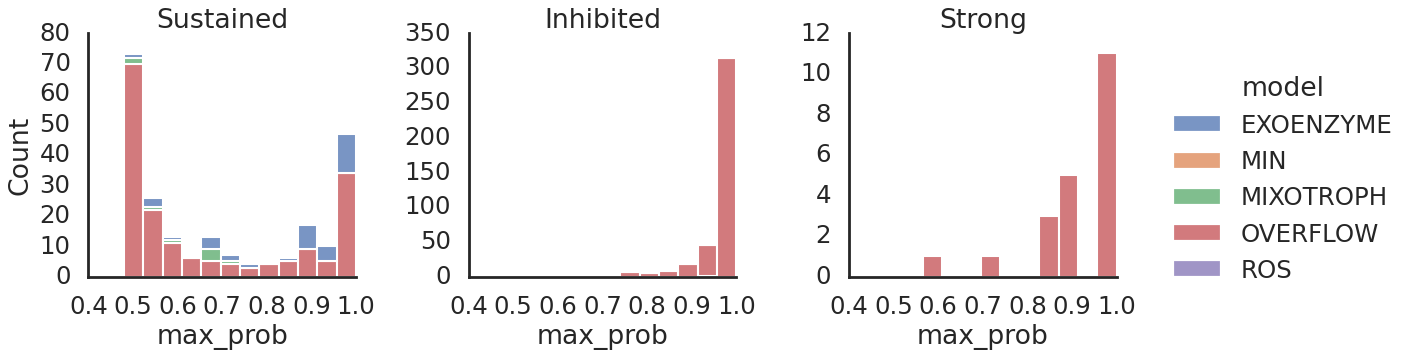

In [52]:
g = sns.displot(
    data=df_predicted_classes.loc[~df_predicted_classes.Group.isin(['Weak'])],
    x='max_prob', 
    col='Group', hue='model', multiple='stack', 
    facet_kws=dict(sharey=False, ),
    #row='model',

)
g.set_titles(col_template='{col_name}')
#g.set(yscale='log')

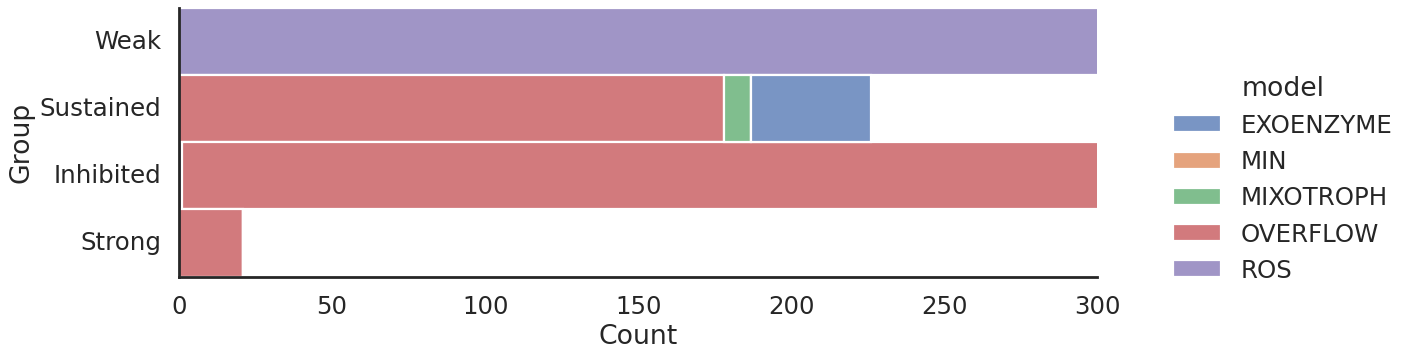

In [93]:
g = sns.displot(
    data=df_predicted_classes.reset_index(),
    #x='max_prob', 
    y='Group', hue='model', #dodge=False,
    #kind='count',
    multiple='stack',
    #legend=False,
    aspect=3,
)
g.set_titles(col_template='{col_name}')
#g.set(xscale='log')
g.set(xlim=(0,300))


In [54]:
sim_df

,run_id,day,Bptotal[N],Bptotal[C],log_Nbiomass,log_Cbiomass
0,monte4_ROS_38_monte_vpro_4876_ROS_59_lowN_all_...,0.000000,0.892857,5.915179,0.000000,1.777522
1,monte4_ROS_38_monte_vpro_4876_ROS_59_lowN_all_...,1.081944,2.479189,11.850470,0.907931,2.472368
2,monte4_ROS_38_monte_vpro_4876_ROS_59_lowN_all_...,2.164583,4.956136,23.678559,1.600626,3.164570
3,monte4_ROS_38_monte_vpro_4876_ROS_59_lowN_all_...,2.747222,7.191525,34.358417,1.972903,3.536847
4,monte4_ROS_38_monte_vpro_4876_ROS_59_lowN_all_...,3.754167,13.683119,65.373152,2.616163,4.180112
...,...,...,...,...,...,...
3232763,monte4_EXOENZYME_99_monte_vpro_3911_EXOENZYME_...,110.943750,0.000017,0.000143,0.000000,0.000000
3232764,monte4_EXOENZYME_99_monte_vpro_3911_EXOENZYME_...,115.845833,0.000009,0.000074,0.000000,0.000000
3232765,monte4_EXOENZYME_99_monte_vpro_3911_EXOENZYME_...,118.788889,0.000006,0.000050,0.000000,0.000000
3232766,monte4_EXOENZYME_99_monte_vpro_3911_EXOENZYME_...,121.777778,0.000004,0.000033,0.000000,0.000000


In [55]:
sample_ids = df_predicted_classes.groupby('Group').run_id.sample(50, replace=True)

In [56]:
sample_df = sim_df.loc[sim_df[f'Bptotal[N]'].ge(1) & sim_df.run_id.isin(sample_ids)]
sample_df = sample_df.merge(df_predicted_classes, on='run_id', how='left')
sample_df

,run_id,day,Bptotal[N],Bptotal[C],log_Nbiomass,log_Cbiomass,y_pred,max_prob,idx,media,which,model,hash,Group
0,monte4_OVERFLOW_35_monte_vpro_3753_OVERFLOW_28...,1.081944,1.249341,8.276884,0.222616,2.113467,Inhibited,0.999298,monte4_OVERFLOW_35_monte_vpro_3753_OVERFLOW_28,lowN,all,OVERFLOW,h-2074384540759412348,Inhibited
1,monte4_MIN_74_monte_vpro_3450_MIN_52_lowN_all_...,1.081944,1.459292,13.088390,0.377951,2.571726,Weak,0.999844,monte4_MIN_74_monte_vpro_3450_MIN_52,lowN,all,MIN,h2914781599285612379,Weak
2,monte4_MIN_74_monte_vpro_3450_MIN_52_lowN_all_...,2.164583,2.318586,20.795413,0.840957,3.034732,Weak,0.999844,monte4_MIN_74_monte_vpro_3450_MIN_52,lowN,all,MIN,h2914781599285612379,Weak
3,monte4_MIN_74_monte_vpro_3450_MIN_52_lowN_all_...,2.747222,2.974089,26.674702,1.089938,3.283716,Weak,0.999844,monte4_MIN_74_monte_vpro_3450_MIN_52,lowN,all,MIN,h2914781599285612379,Weak
4,monte4_MIN_74_monte_vpro_3450_MIN_52_lowN_all_...,3.754167,4.573112,41.016706,1.520194,3.713979,Weak,0.999844,monte4_MIN_74_monte_vpro_3450_MIN_52,lowN,all,MIN,h2914781599285612379,Weak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_...,20.778472,2.619842,25.401383,0.963114,3.234804,Weak,0.999625,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_83,lowN,all,EXOENZYME,h1628948357718170805,Weak
4945,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_...,21.880556,2.206793,21.393412,0.791540,3.063083,Weak,0.999625,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_83,lowN,all,EXOENZYME,h1628948357718170805,Weak
4946,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_...,23.898611,1.616192,15.664868,0.480073,2.751420,Weak,0.999625,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_83,lowN,all,EXOENZYME,h1628948357718170805,Weak
4947,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_...,25.734722,1.220004,11.823422,0.198854,2.470082,Weak,0.999625,monte4_EXOENZYME_34_monte_vpro_3440_EXOENZYME_83,lowN,all,EXOENZYME,h1628948357718170805,Weak


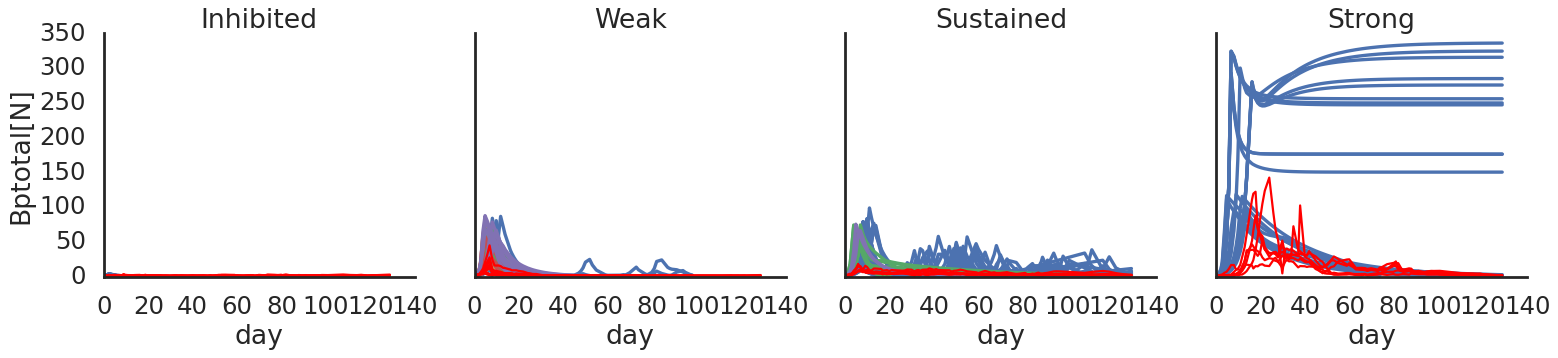

In [57]:
    g = sns.relplot(
        data=sample_df,
        kind='line', 
        estimator=None, units='run_id',
        hue='model',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    #g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

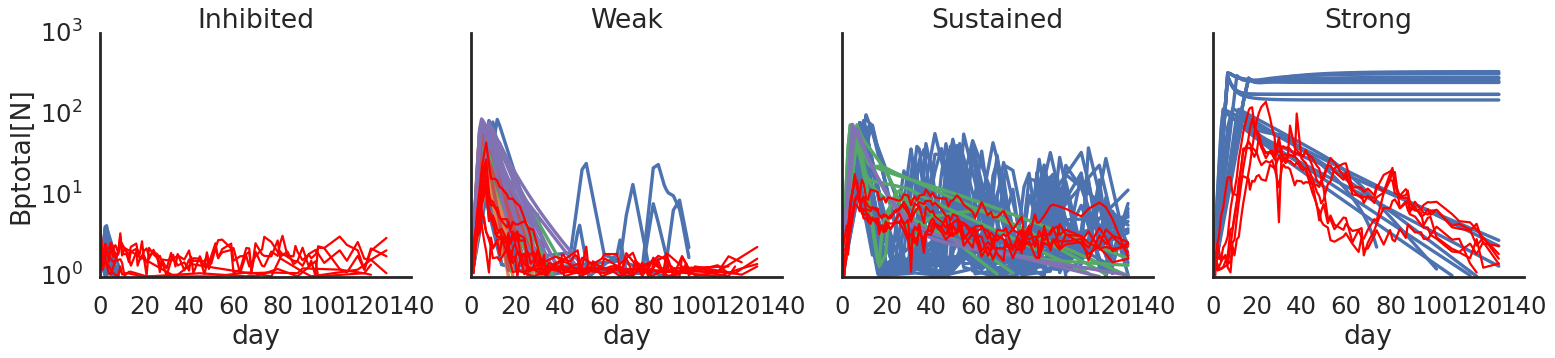

In [58]:
    g = sns.relplot(
        data=sample_df,
        kind='line', 
        estimator=None, units='run_id',
        hue='model',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

In [84]:
sample_ids2 = df_predicted_classes.loc[df_predicted_classes.max_prob.ge(0.7)
                                      ].groupby('Group').run_id.sample(10, replace=True)

In [85]:
sample_df2 = sim_df.loc[sim_df[f'Bptotal[N]'].ge(1) & sim_df.run_id.isin(sample_ids2)]
sample_df2 = sample_df2.merge(df_predicted_classes, on='run_id', how='left')


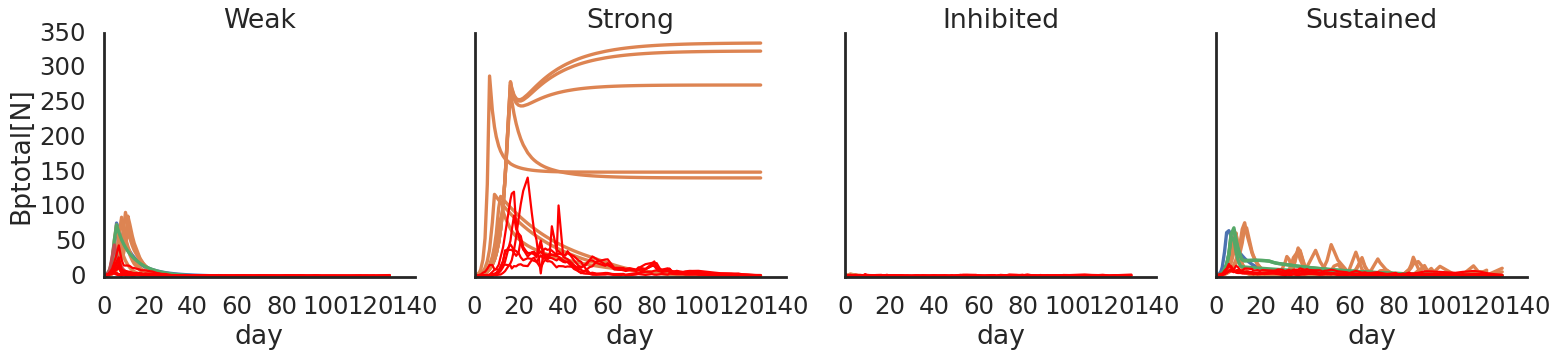

In [86]:
    g = sns.relplot(
        data=sample_df2,
        kind='line', 
        estimator=None, units='run_id',
        hue='model',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    #g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

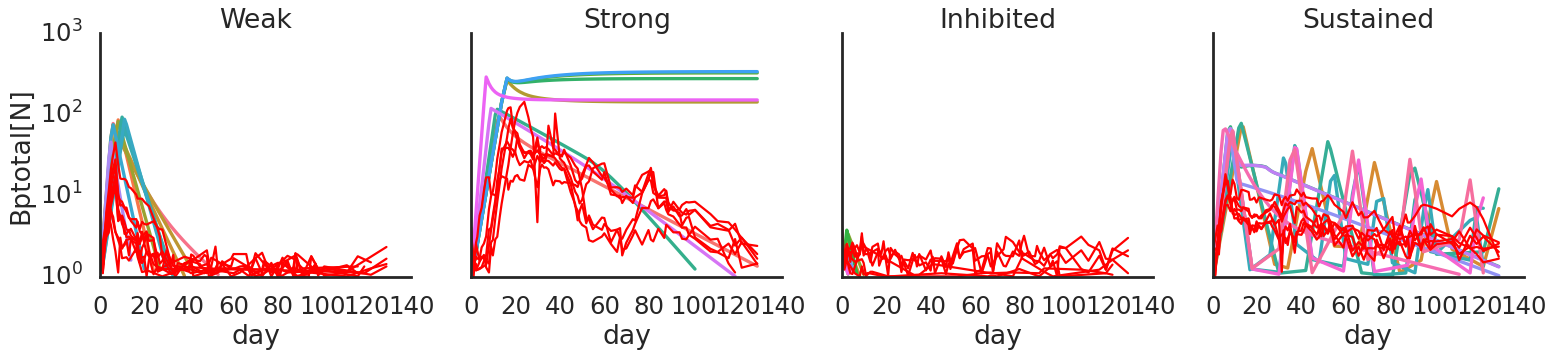

In [89]:
    g = sns.relplot(
        data=sample_df2,
        kind='line', 
        estimator=None, units='run_id',
        hue='run_id',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

In [94]:
sample_ids3 = df_predicted_classes.loc[df_predicted_classes.max_prob.lt(0.5)
                                      ].groupby('Group').run_id.sample(10, replace=True)

In [95]:
sample_df3 = sim_df.loc[sim_df[f'Bptotal[N]'].ge(1) & sim_df.run_id.isin(sample_ids3)]
sample_df3 = sample_df3.merge(df_predicted_classes, on='run_id', how='left')


In [96]:
sample_df3

,run_id,day,Bptotal[N],Bptotal[C],log_Nbiomass,log_Cbiomass,y_pred,max_prob,idx,media,which,model,hash,Group
0,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88...,1.081944,1.571470,10.410991,0.452012,2.342862,Sustained,0.488430,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88,lowN,all,OVERFLOW,h-2074384540759412348,Sustained
1,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88...,2.164583,2.645415,17.525872,0.972828,2.863678,Sustained,0.488430,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88,lowN,all,OVERFLOW,h-2074384540759412348,Sustained
2,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88...,2.747222,3.500686,23.192043,1.252959,3.143809,Sustained,0.488430,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88,lowN,all,OVERFLOW,h-2074384540759412348,Sustained
3,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88...,3.754167,5.680799,37.635297,1.737092,3.627942,Sustained,0.488430,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88,lowN,all,OVERFLOW,h-2074384540759412348,Sustained
4,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88...,4.701389,8.957675,59.344599,2.192511,4.083361,Sustained,0.488430,monte4_OVERFLOW_59_monte_vpro_3806_OVERFLOW_88,lowN,all,OVERFLOW,h-2074384540759412348,Sustained
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21...,88.748611,1.143085,7.572940,0.133731,2.024581,Weak,0.479876,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21,lowN,all,OVERFLOW,h-2074384540759412348,Weak
590,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21...,107.714583,4.838241,32.053345,1.576551,3.467402,Weak,0.479876,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21,lowN,all,OVERFLOW,h-2074384540759412348,Weak
591,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21...,110.943750,21.249668,140.779051,3.056341,4.947192,Weak,0.479876,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21,lowN,all,OVERFLOW,h-2074384540759412348,Weak
592,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21...,115.845833,5.334503,35.341079,1.674196,3.565046,Weak,0.479876,monte4_OVERFLOW_50_monte_vpro_4225_OVERFLOW_21,lowN,all,OVERFLOW,h-2074384540759412348,Weak


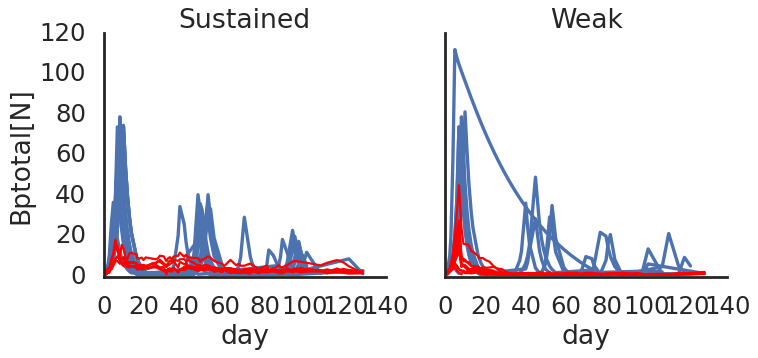

In [97]:
    g = sns.relplot(
        data=sample_df3,
        kind='line', 
        estimator=None, units='run_id',
        hue='model',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    #g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

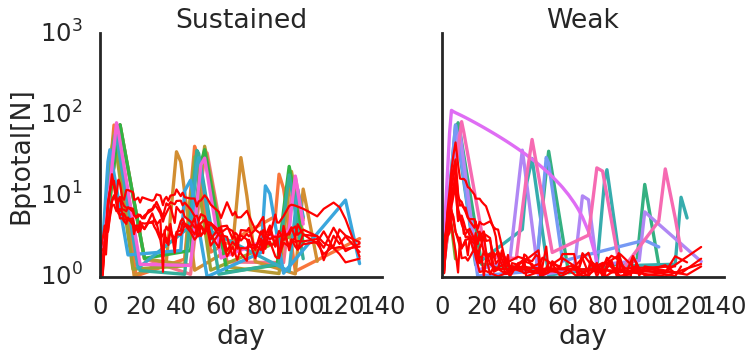

In [98]:
    g = sns.relplot(
        data=sample_df3,
        kind='line', 
        estimator=None, units='run_id',
        hue='run_id',
        #hue='model',
        x='day', y=f'Bptotal[N]', 
        col='Group', #col_wrap=3,
        facet_kws=dict( margin_titles=True),
        legend=False
    )
    for (col_val), ax in g.axes_dict.items():
        sns.lineplot(
            data=refdf.loc[refdf[f'ref_Bp[N]'].ge(1) & refdf['Group'].isin([col_val])],
            x='day', y=f'ref_Bp[N]',
        units='Sample', estimator=None, ax=ax, lw=2, color='red',

                     legend=False
                    )
    g.set(yscale='log')
    g.set_titles(col_template='{col_name}', row_template='{row_name}')

In [99]:
class_meta_df

,id,full name,Group,0
0,2,A. macleodii 1A3,Strong,222
1,3,Marinobacter adhaerens HP15,Inhibited,222
2,4,Phaeobacter gallaeciensis,Inhibited,222
3,5,Pseudoalteromonas haloplanktis,Strong,222
4,6,Ruegeria pomeroyi,Sustained,222
5,7,Sulfitobacter pseudonitzschiae,Sustained,222
6,9,E. coli,Weak,222
7,10,Marinovum 5F3,Weak,222
8,11,Roseovarius 5C3,Weak,222


In [69]:
list(zip(*np.unique(y_sim_pred, return_counts=True)))

[('Inhibited', 410), ('Strong', 21), ('Sustained', 226), ('Weak', 41939)]

In [70]:
stack.classes_

array(['Inhibited', 'Strong', 'Sustained', 'Weak'], dtype=object)

In [71]:
refdf[['id', 'Group']].value_counts()

id  Group    
2   Strong       222
3   Inhibited    222
4   Inhibited    222
5   Strong       222
6   Sustained    222
7   Sustained    222
9   Weak         222
10  Weak         222
11  Weak         222
dtype: int64

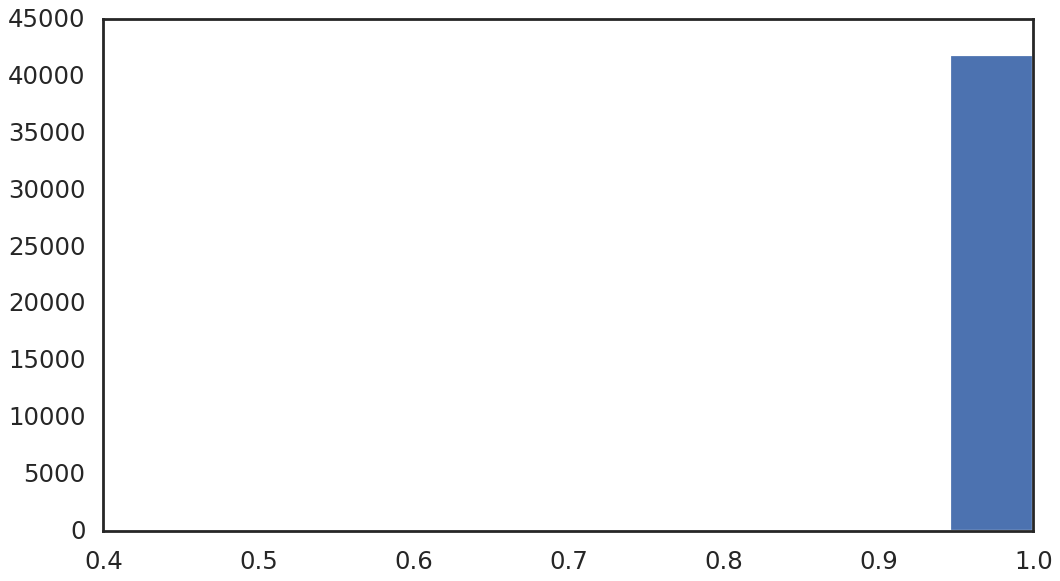

In [72]:
plt.hist(max_sim_prob)  
plt.show()

In [73]:
max_sim_prob.shape

(42596,)

In [75]:
import joblib  
#import dump, load

In [ ]:
joblib.dump(stack, 'Model_clasification.')